In [1]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_len = len(stoi)
vocab_len

27

In [4]:
block_size = 8
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [5]:
class Container:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

class Embedding:
    def __init__(self, vocab_len, num_embs):
        self.weight = torch.randn(vocab_len, num_embs)
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = torch.squeeze(x, 1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []
    
class linear:
    def __init__(self, fan_in, fan_out, bias=False):
        self.weight = torch.randn(fan_in, fan_out) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight 
        if self.bias is not None:
            self.out += self.bias
        else: pass
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-05, momentum=0.1):
        self.dim = dim
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.running_mean =  torch.zeros(dim)
        self.running_var = torch.ones(dim)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            if x.ndim == 3:
                dim =(0,1)
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        if self.training:
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [ self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [6]:
torch.manual_seed(42)

In [27]:
num_embd = 10
n_hidden = 200

model = Container([
    Embedding(vocab_len, num_embd),
    FlattenConsecutive(2), linear(num_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    linear(n_hidden, vocab_len)
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

170870


In [28]:
max_steps = 20000
batch_size = 300
lossi = []
ud = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    x = Xb
    logits = model(x)
    loss = F.cross_entropy(logits, Yb)
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.5 if i < 15000 else 0.05
    for p in parameters:
        p.data += - lr * p.grad
    if i % 1000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()) for p in parameters])

      0/  20000: 3.2924
   1000/  20000: 2.1460
   2000/  20000: 2.0304
   3000/  20000: 2.2163
   4000/  20000: 2.0488
   5000/  20000: 1.9435
   6000/  20000: 1.9632
   7000/  20000: 1.9407
   8000/  20000: 1.9197
   9000/  20000: 1.8709
  10000/  20000: 1.8444
  11000/  20000: 1.8648
  12000/  20000: 1.9533
  13000/  20000: 1.9314
  14000/  20000: 1.8124
  15000/  20000: 1.8145
  16000/  20000: 1.8106
  17000/  20000: 1.6996
  18000/  20000: 1.7211
  19000/  20000: 1.5349


layers 4 (      Tanh): mean -0.02, std 0.56, saturated: 13.98%
layers 8 (      Tanh): mean -0.00, std 0.64, saturated: 19.52%
layers 12 (      Tanh): mean +0.01, std 0.74, saturated: 16.57%


Text(0.5, 1.0, 'Activation functions distribution.')

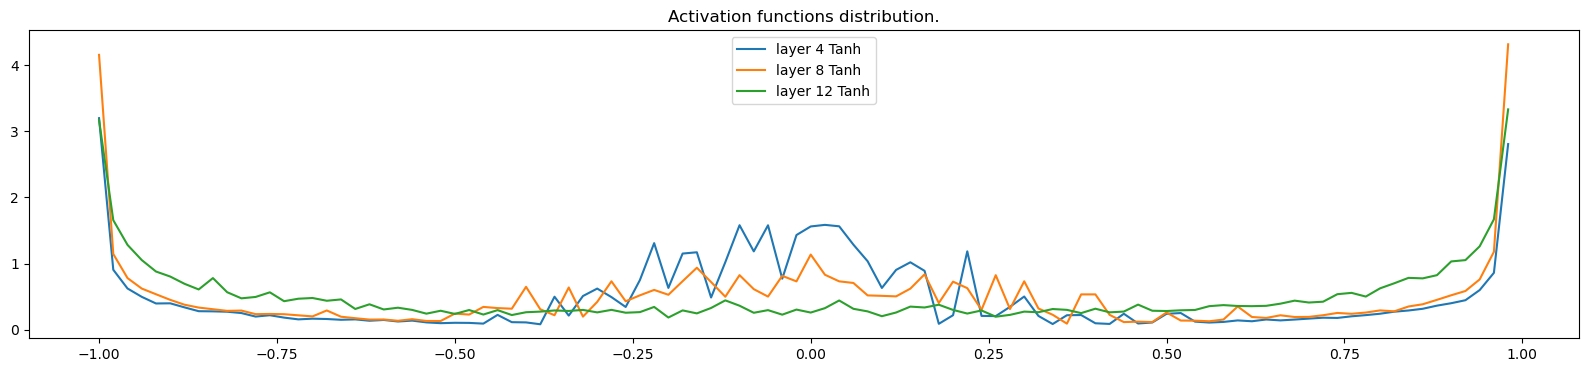

In [29]:
# visualize histograms: see the activation functions saturation.
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(model.layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layers %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} {layer.__class__.__name__}')
plt.legend(legends);
plt.title('Activation functions distribution.')

weight   (27, 10) | mean +0.000000 | std8.532918e-03 | grad data: ratio 7.783805e-03
weight  (20, 200) | mean +0.000062 | std4.432977e-03 | grad data: ratio 1.373698e-02
weight (400, 200) | mean +0.000002 | std1.957262e-03 | grad data: ratio 1.710407e-02
weight (400, 200) | mean +0.000006 | std1.926190e-03 | grad data: ratio 1.673617e-02
weight  (200, 27) | mean +0.000000 | std6.810578e-03 | grad data: ratio 3.229062e-02


Text(0.5, 1.0, 'Weights gradient distribution')

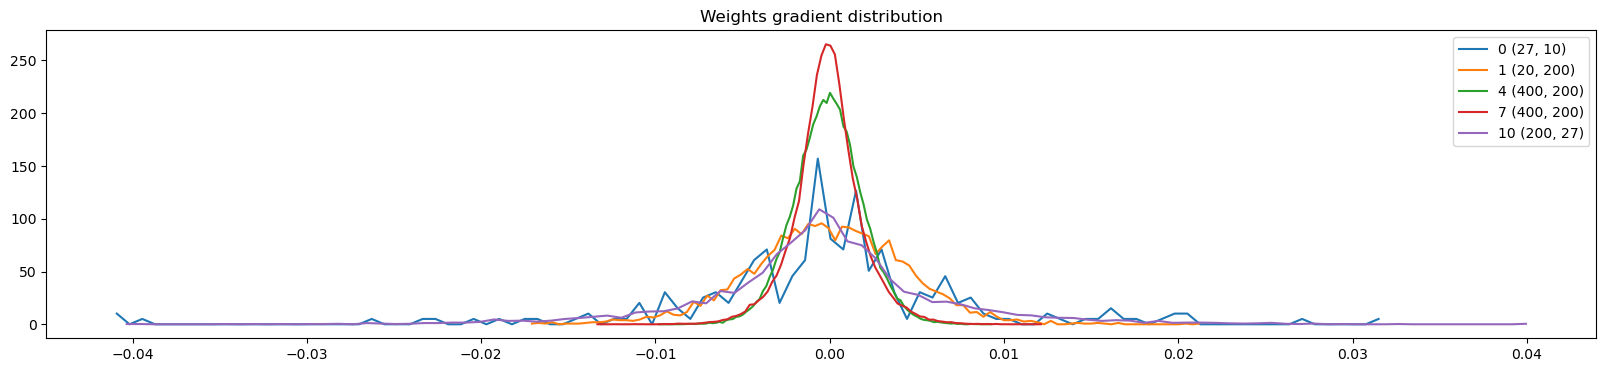

In [30]:
# visualize histogram: see how the gradients from the weights are distributed.
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std%e | grad data: ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('Weights gradient distribution')

In [33]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
for layer in model.layers:
    layer.training  = False
split_loss('train')
split_loss('val')
split_loss('test')

train 1.6995848417282104
val 2.012434720993042
test 2.0058531761169434


In [ ]:
# with learning rate 0.01, 0.001
# train 2.0229480266571045
# val 2.0744595527648926
# test 2.0700032711029053

In [35]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

haron.
madaslin.
mathan.
jonnie.
rilyn.
josette.
baysen.
devansen.
jaleia.
khylee.
zymus.
izsa.
mahleigh.
collynne.
ridley.
liasvynn.
caiyana.
rylie.
riott.
kasha.
